<a href="https://colab.research.google.com/github/shielamms/Tensorflow-Notebooks/blob/main/Deep_Neural_Network_Training_on_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Generate Synthetic Data

### Plotting function

In [3]:
def plot_series(time, series, format='-', start=0, end=None, figsize=(10,6)):
  plt.figure(figsize=figsize)

  if isinstance(series, tuple):
    for s in series:
      plt.plot(time[start:end], s[start:end], format)
  else:
    plt.plot(time[start:end], series[start:end], format)

  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)
  plt.show()

### Time series properties

In [4]:
def trend(time, slope=0):
  """
  Generate synthetic time series data following a straight line of a given slope
  """

  return slope * time


def seasonality(time, period, amplitude=1, phase=0):
  """
  Repeat an arbitrary pattern at each period
  """

  def seasonal_pattern(season_time):
    """
    Generate an arbitrary pattern simulating a seasonal pattern
    """
    pattern = np.where(season_time < 0.4,
                      np.cos(season_time * 2 * np.pi),
                      1 / np.exp(3 * season_time))
    return pattern
  
  season_time = ((time + phase) % period) / period
  data_pattern = amplitude * seasonal_pattern(season_time)
  return data_pattern


def noise(time, noise_level=1, seed=None):
  """
  Generate normally distributed noisy data
  """

  rnd = np.random.RandomState(seed)
  noise = rnd.randn(len(time)) * noise_level
  return noise


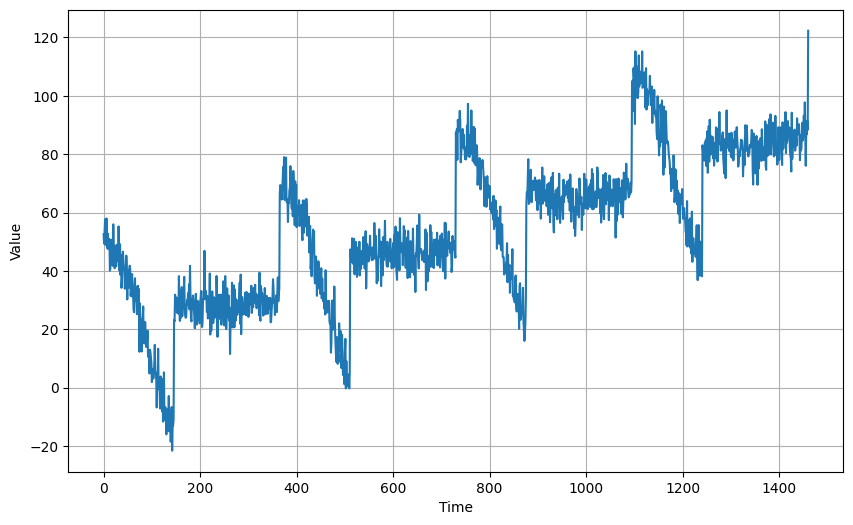

In [5]:
time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = (
    baseline
    + trend(time, slope)
    + seasonality(time, period=365, amplitude=amplitude)
)

series += noise(time, noise_level, seed=42)

plot_series(time, series)

### Train and validation split

In [6]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

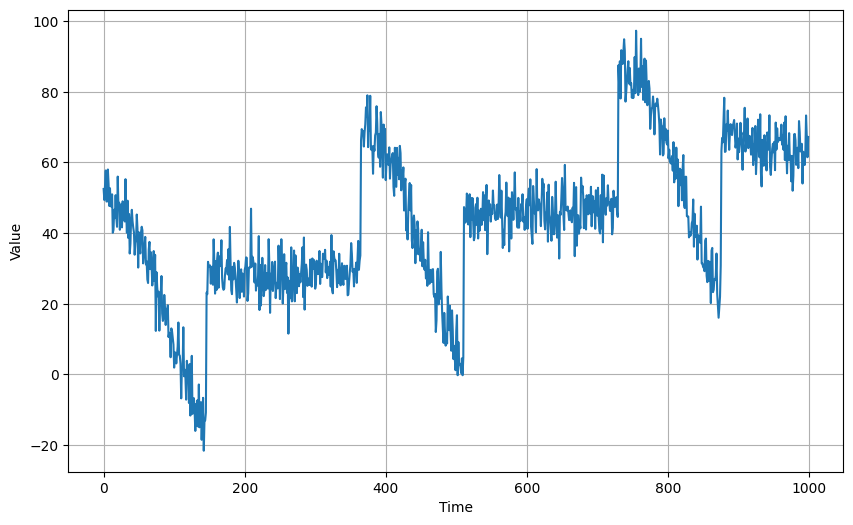

In [7]:
plot_series(time_train, x_train)

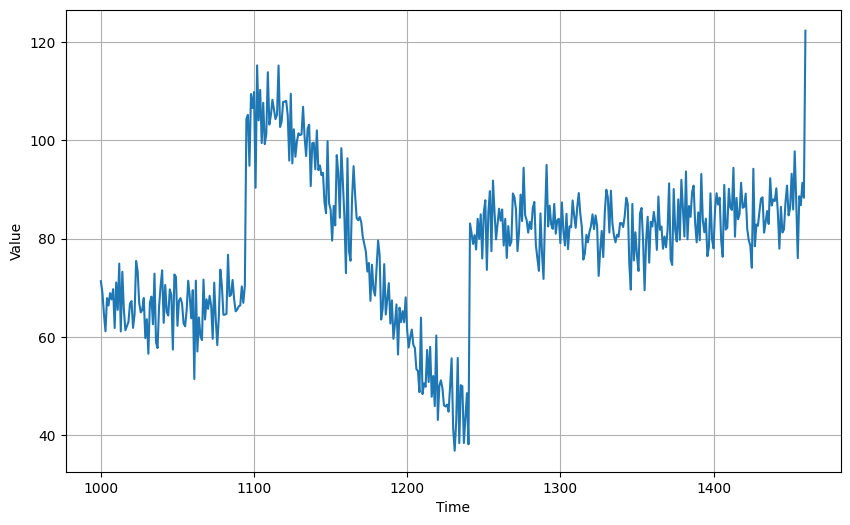

In [8]:
plot_series(time_valid, x_valid)

## Windowed Data Prep

### Sample

In [9]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(size=5, shift=1, drop_remainder=True)

# for data in dataset:
#   print([val.numpy() for val in data])

# Flatten dataset into a tensor
dataset = dataset.flat_map(lambda window: window.batch(5))

# Split dataset to features and labels, then shuffle the time windows
dataset = dataset.map(lambda x: (x[:-1], x[-1])).shuffle(buffer_size=10)

# Create batches of windows
dataset = dataset.batch(2).prefetch(1)

for x,y in dataset:
  print(f'X = {x}')
  print(f'y = {y}')
  print()

X = [[4 5 6 7]
 [3 4 5 6]]
y = [8 7]

X = [[5 6 7 8]
 [2 3 4 5]]
y = [9 6]

X = [[1 2 3 4]
 [0 1 2 3]]
y = [5 4]



### On the dataset

In [10]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [13]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


## Build the model

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[window_size])
])

print("Layer weights: \n {} \n".format(model.get_weights()))


Layer weights: 
 [array([[ 0.12469119],
       [-0.42679825],
       [-0.46962336],
       [ 0.47816104],
       [-0.03227866],
       [ 0.00122035],
       [ 0.25473362],
       [ 0.15973926],
       [-0.0875693 ],
       [-0.4337542 ],
       [ 0.22843635],
       [-0.51628286],
       [ 0.3861227 ],
       [-0.33279297],
       [ 0.39116424],
       [-0.47933418],
       [ 0.38136512],
       [ 0.04839116],
       [ 0.4574319 ],
       [-0.52988696]], dtype=float32), array([0.], dtype=float32)] 



In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6,
                                                momentum=0.9))

## Train the model

In [17]:
EPOCHS = 100

history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/100
31/31 [==============================] - 3s 57ms/step - loss: 813.4330
Epoch 2/100
31/31 [==============================] - 1s 7ms/step - loss: 172.4201
Epoch 3/100
31/31 [==============================] - 1s 15ms/step - loss: 131.8384
Epoch 4/100
31/31 [==============================] - 1s 5ms/step - loss: 128.1317
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: 120.0122
Epoch 6/100
31/31 [==============================] - 1s 8ms/step - loss: 116.2718
Epoch 7/100
31/31 [==============================] - 1s 11ms/step - loss: 114.5640
Epoch 8/100
31/31 [==============================] - 1s 8ms/step - loss: 110.3094
Epoch 9/100
31/31 [==============================] - 1s 13ms/step - loss: 108.0304
Epoch 10/100
31/31 [==============================] - 1s 12ms/step - loss: 105.2335
Epoch 11/100
31/31 [==============================] - 1s 5ms/step - loss: 102.8352
Epoch 12/100
31/31 [==============================] - 1s 8ms/step - loss: 101.1206
Epoch 1

## Prediction

In [20]:
print(f'shape of series[0:20]: {series[0:20].shape}')

shape of series[0:20]: (20,)


In [18]:
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

shape of series[0:20][np.newaxis]: (1, 20)


In [22]:
print(f'model prediction: {model.predict(np.expand_dims(series[0:20], axis=0))}')

1/1 [==============================] - 0s 76ms/step
model prediction: [[45.313526]]


In [25]:
forecast = []

for time in range(len(series) - window_size):
  prediction = model.predict(np.expand_dims(series[time:time+window_size],
                                            axis=0))
  forecast.append(prediction)

# Slice to the first prediction in the validation set
# (the predictors are the 20 units before the first unit of the validation set)
forecast = forecast[split_time-window_size:]

print(f'Length of forecast: {len(forecast)}')
print(f'Shape of validation set: {x_valid.shape}')


1/1 [==============================] - 0s 32ms/step
Length of forecast: 461
Shape of validation set: (461,)


In [26]:
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')


shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


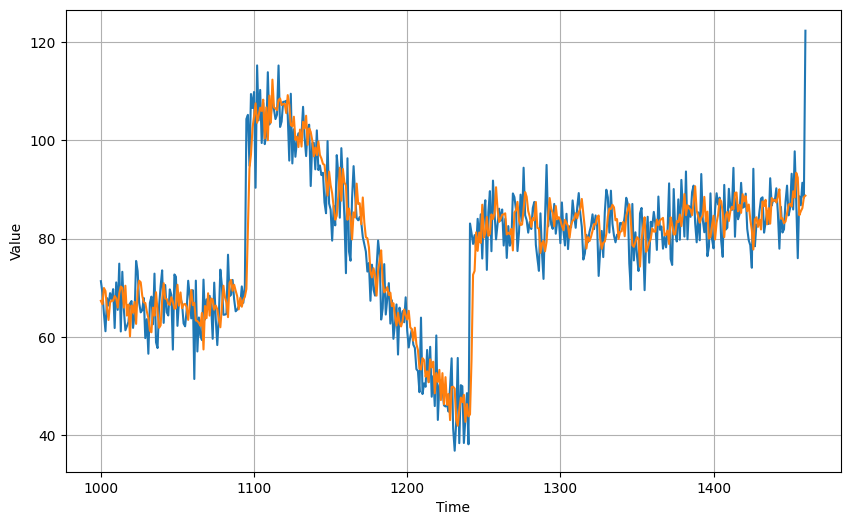

In [27]:
# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
plot_series(time_valid, (x_valid, results))

In [30]:
print(f'Mean squared error: {tf.keras.metrics.mean_squared_error(x_valid, results).numpy()}')
print(f'Mean absolute error: {tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()}')

Mean squared error: 44.96657943725586
Mean absolute error: 4.981775760650635
